## Generative Adversarial Network (GAN)

https://www.datacamp.com/community/tutorials/generative-adversarial-networks

Two major componants in GAN are generator and discriminator. The discriminator is a classifier that tells good from bad or apples from oranges. The generator is a model that takes in a random vector and output something that could fool the discriminator. The goal is to train a generator that could bypass the discriminator.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # this is from keras and auto loads the dataset
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [3]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

### What is `get_gan_network`
Here we get the GAN network by the function `get_gan_network`. The function returns a model with input a random vector of length 100. The generator uses this random vector as input and generates a picture. The picture is then fed into discriminator. The model output is the probability of the image being a number by the discriminator.

### How to Train the Generator and Discriminator.
Training of generator and discriminator are in seperated steps. As specified by the train function below, we first use random images from generator as unreal numbers and training data as 90% real numbers to train the __discriminator__.

Then we fix the discriminator by setting `discriminator.trainable = False` and use the GAN from `get_gan_network` to train the __generator__. Note that input here is a random vector and out is the probability of image generated being a real number.

In [4]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 1/468 [00:00<01:03,  7.37it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/468 [00:00<00:50,  9.22it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/468 [00:00<00:50,  9.25it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/468 [00:00<00:52,  8.82it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/468 [00:00<00:53,  8.66it/s]

--------------- Epoch 6 ---------------


  0%|          | 1/468 [00:00<00:51,  9.15it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/468 [00:00<00:53,  8.80it/s]

--------------- Epoch 8 ---------------


  0%|          | 1/468 [00:00<00:52,  8.90it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/468 [00:00<00:50,  9.29it/s]

--------------- Epoch 10 ---------------


  0%|          | 1/468 [00:00<00:58,  8.01it/s]

--------------- Epoch 11 ---------------


  0%|          | 1/468 [00:00<00:51,  9.00it/s]

--------------- Epoch 12 ---------------


  0%|          | 1/468 [00:00<00:50,  9.21it/s]

--------------- Epoch 13 ---------------


  0%|          | 1/468 [00:00<00:54,  8.57it/s]

--------------- Epoch 14 ---------------


  0%|          | 1/468 [00:00<00:57,  8.12it/s]

--------------- Epoch 15 ---------------


  0%|          | 1/468 [00:00<00:54,  8.62it/s]

--------------- Epoch 16 ---------------


  0%|          | 1/468 [00:00<00:56,  8.27it/s]

--------------- Epoch 17 ---------------


  0%|          | 1/468 [00:00<00:52,  8.95it/s]

--------------- Epoch 18 ---------------


  0%|          | 1/468 [00:00<00:52,  8.85it/s]

--------------- Epoch 19 ---------------


  0%|          | 1/468 [00:00<00:58,  8.05it/s]

--------------- Epoch 20 ---------------


  0%|          | 1/468 [00:00<00:59,  7.87it/s]

--------------- Epoch 21 ---------------


  0%|          | 1/468 [00:00<00:56,  8.25it/s]

--------------- Epoch 22 ---------------


  0%|          | 1/468 [00:00<00:59,  7.91it/s]

--------------- Epoch 23 ---------------


  0%|          | 1/468 [00:00<01:02,  7.49it/s]

--------------- Epoch 24 ---------------


  0%|          | 1/468 [00:00<00:51,  9.02it/s]

--------------- Epoch 25 ---------------


  0%|          | 1/468 [00:00<00:59,  7.88it/s]

--------------- Epoch 26 ---------------


  0%|          | 1/468 [00:00<00:54,  8.59it/s]

--------------- Epoch 27 ---------------


  0%|          | 1/468 [00:00<00:48,  9.70it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:44, 10.36it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:44, 10.39it/s]

--------------- Epoch 30 ---------------


  0%|          | 1/468 [00:00<00:56,  8.20it/s]

--------------- Epoch 31 ---------------


  0%|          | 1/468 [00:00<00:48,  9.69it/s]

--------------- Epoch 32 ---------------


  0%|          | 1/468 [00:00<00:48,  9.69it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:45, 10.15it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:44, 10.50it/s]

--------------- Epoch 35 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------


  0%|          | 1/468 [00:00<00:48,  9.53it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:44, 10.36it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:45, 10.34it/s]

--------------- Epoch 39 ---------------


  0%|          | 1/468 [00:00<00:47,  9.83it/s]

--------------- Epoch 40 ---------------


  0%|          | 1/468 [00:00<00:48,  9.69it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:43, 10.69it/s]

--------------- Epoch 42 ---------------


  0%|          | 1/468 [00:00<00:57,  8.19it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:46, 10.06it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:43, 10.67it/s]

--------------- Epoch 45 ---------------


  0%|          | 1/468 [00:00<00:49,  9.45it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:45, 10.31it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:42, 10.86it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:45, 10.32it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:44, 10.36it/s]

--------------- Epoch 50 ---------------


  0%|          | 1/468 [00:00<00:49,  9.34it/s]

--------------- Epoch 51 ---------------


  0%|          | 1/468 [00:00<00:46,  9.99it/s]

--------------- Epoch 52 ---------------


  0%|          | 1/468 [00:00<00:48,  9.56it/s]

--------------- Epoch 53 ---------------


  0%|          | 1/468 [00:00<00:50,  9.19it/s]

--------------- Epoch 54 ---------------


  0%|          | 2/468 [00:00<00:44, 10.46it/s]

--------------- Epoch 55 ---------------


  0%|          | 1/468 [00:00<00:55,  8.35it/s]

--------------- Epoch 56 ---------------


  0%|          | 2/468 [00:00<00:44, 10.52it/s]

--------------- Epoch 57 ---------------


  0%|          | 2/468 [00:00<00:45, 10.25it/s]

--------------- Epoch 58 ---------------


  0%|          | 2/468 [00:00<00:44, 10.49it/s]

--------------- Epoch 59 ---------------


  0%|          | 1/468 [00:00<00:49,  9.47it/s]

--------------- Epoch 60 ---------------


  0%|          | 1/468 [00:00<00:49,  9.47it/s]

--------------- Epoch 61 ---------------


  0%|          | 2/468 [00:00<00:43, 10.65it/s]

--------------- Epoch 62 ---------------


 18%|█▊        | 85/468 [00:09<00:52,  7.33it/s]


KeyboardInterrupt: 

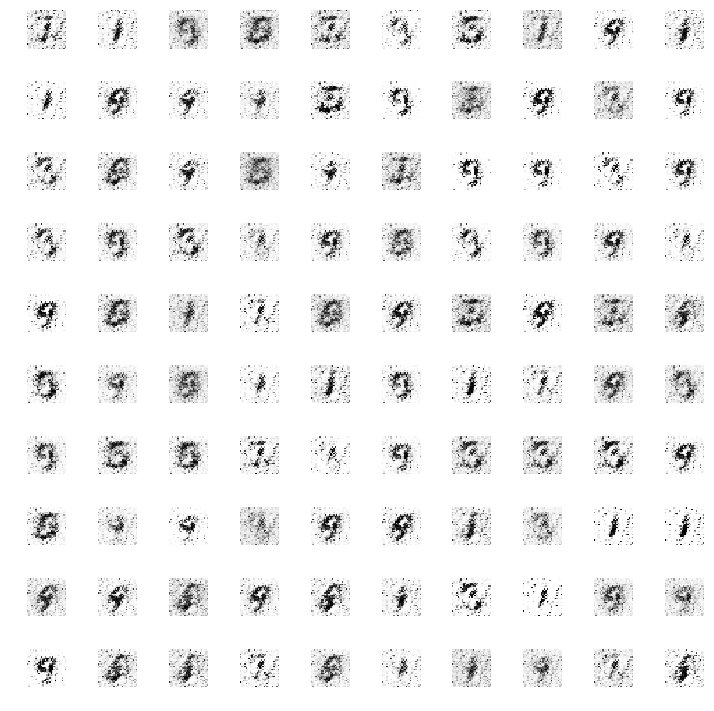

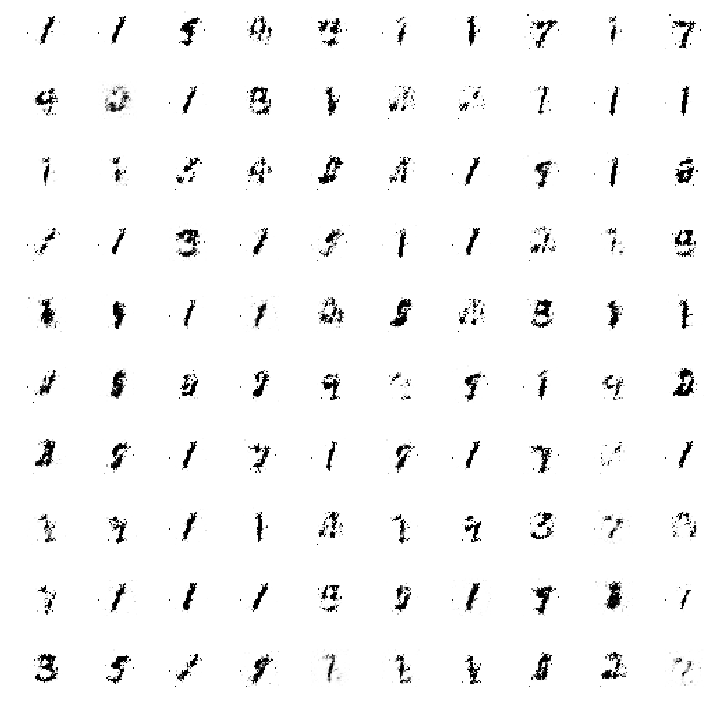

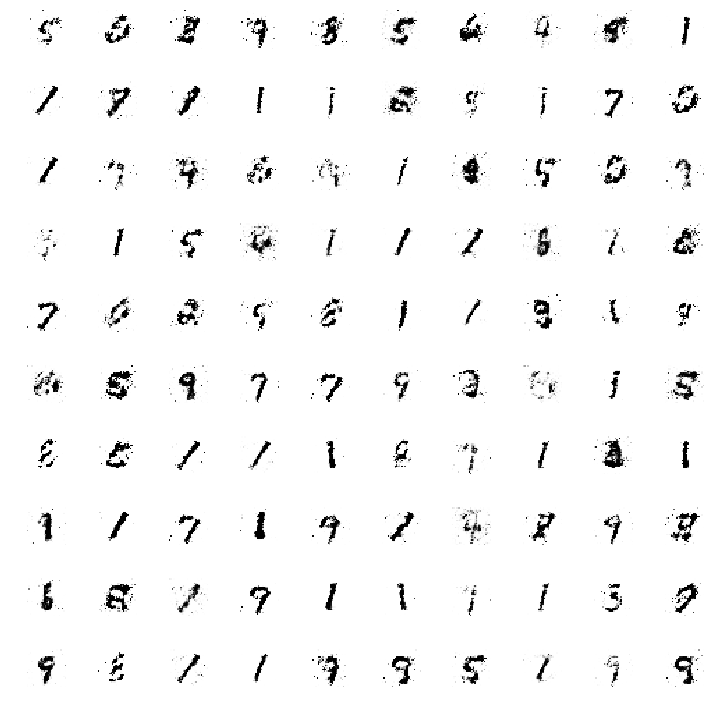

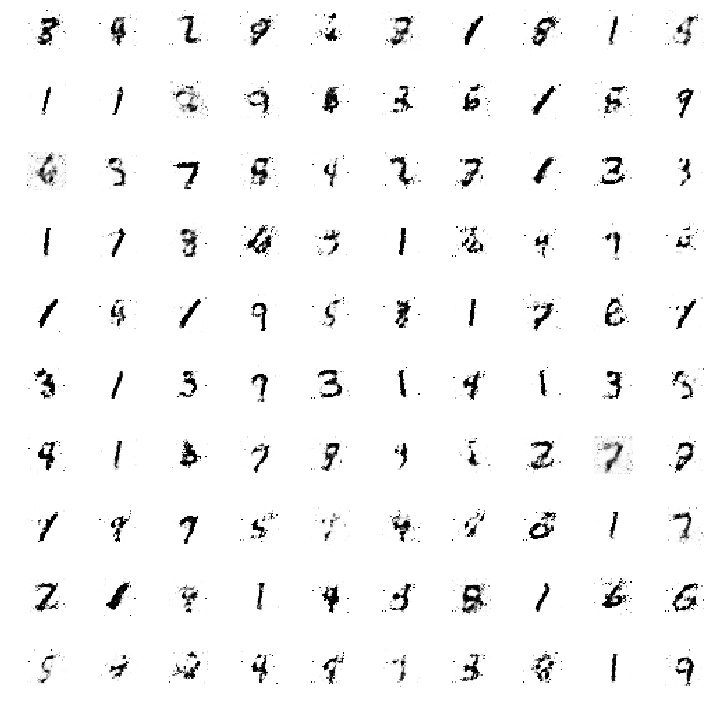

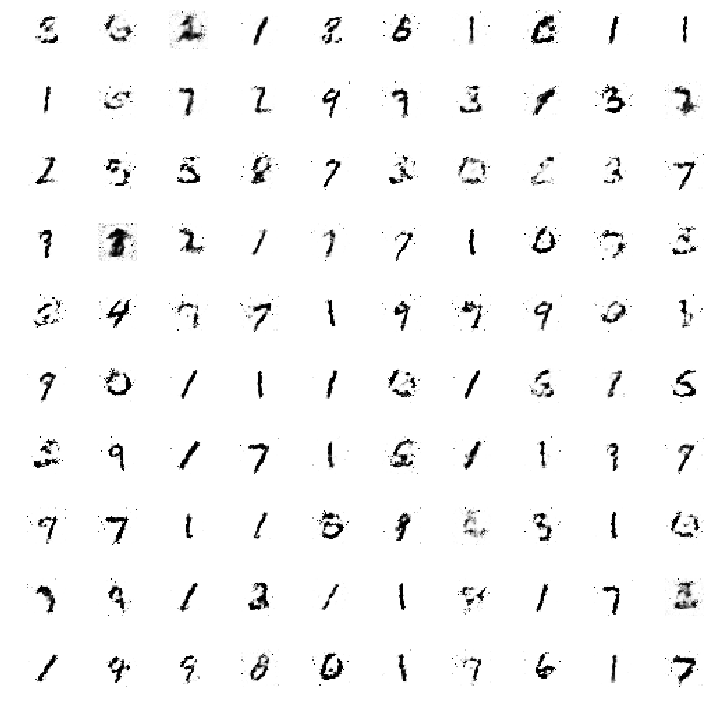

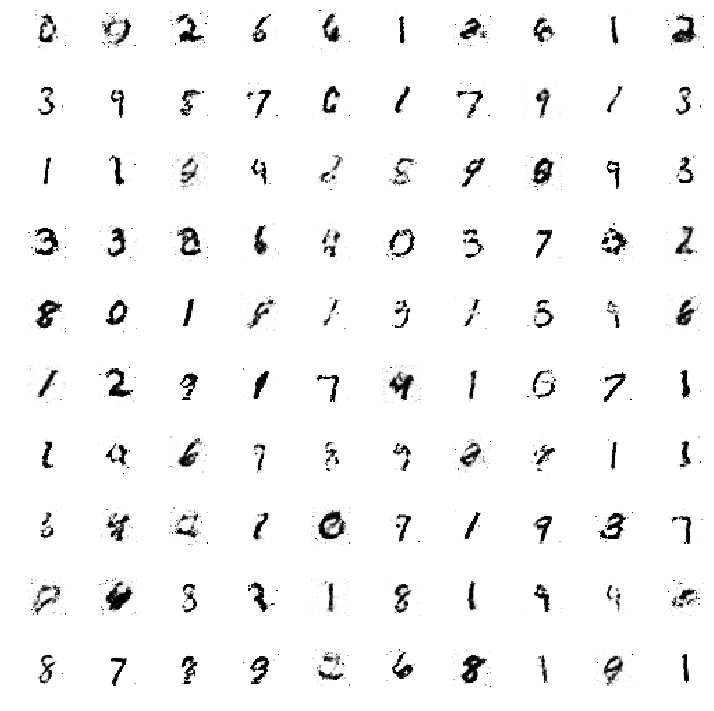

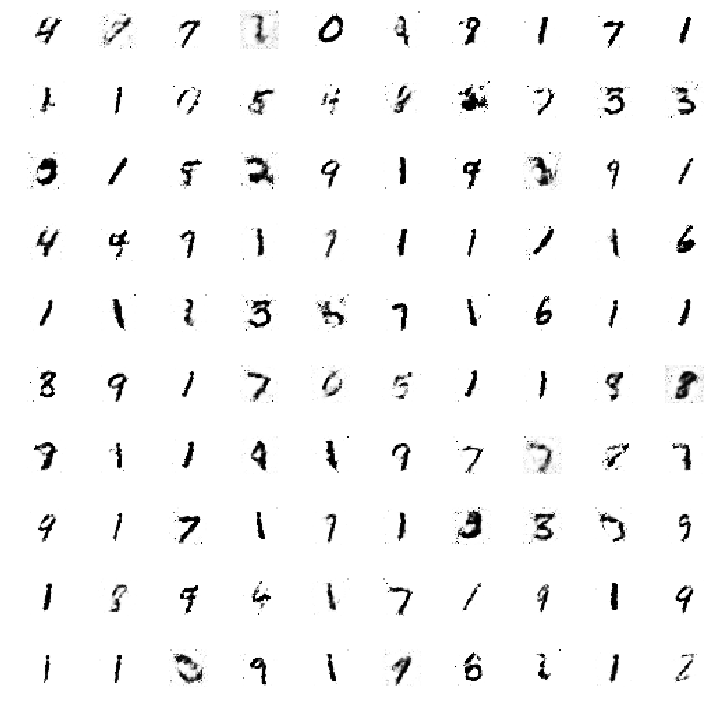

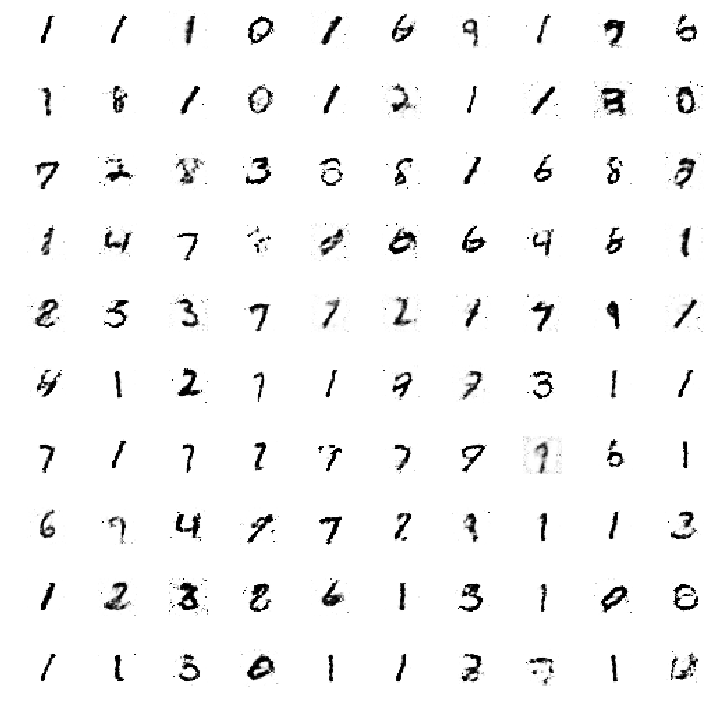

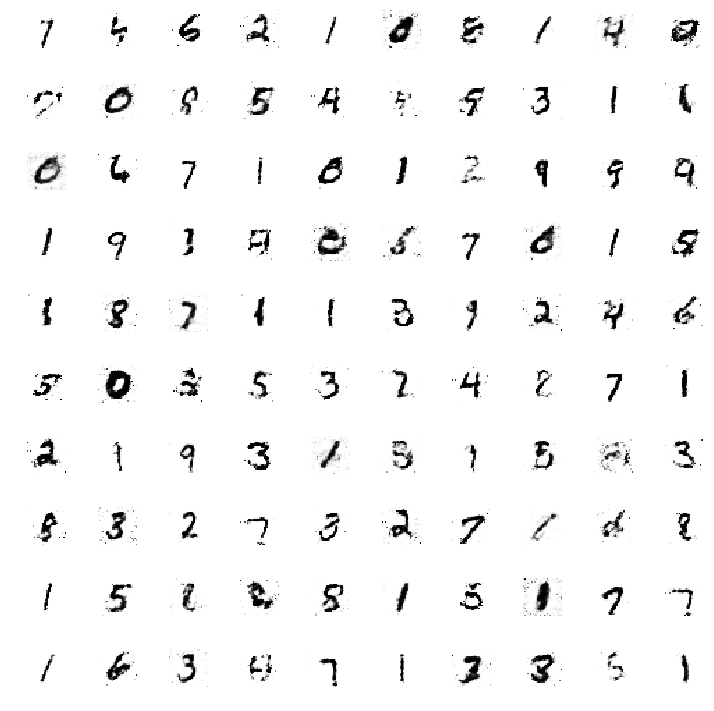

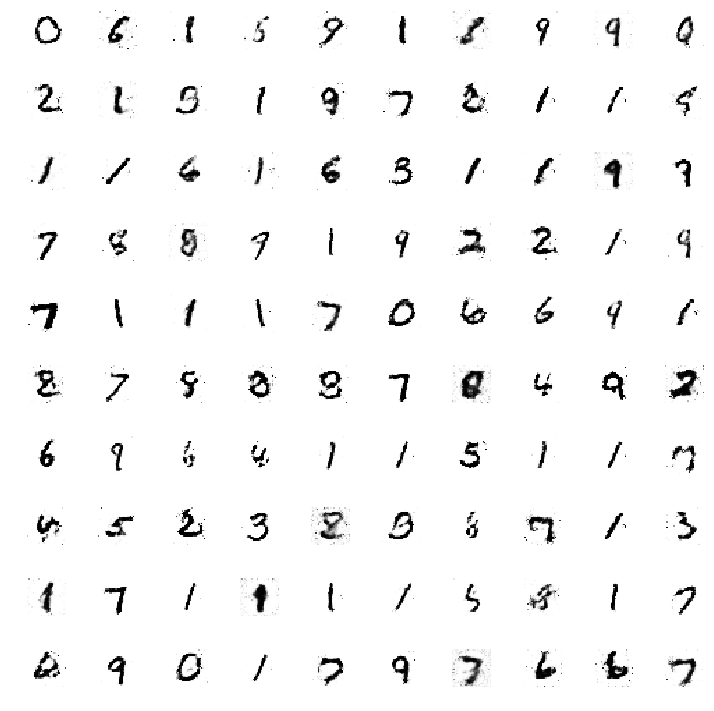

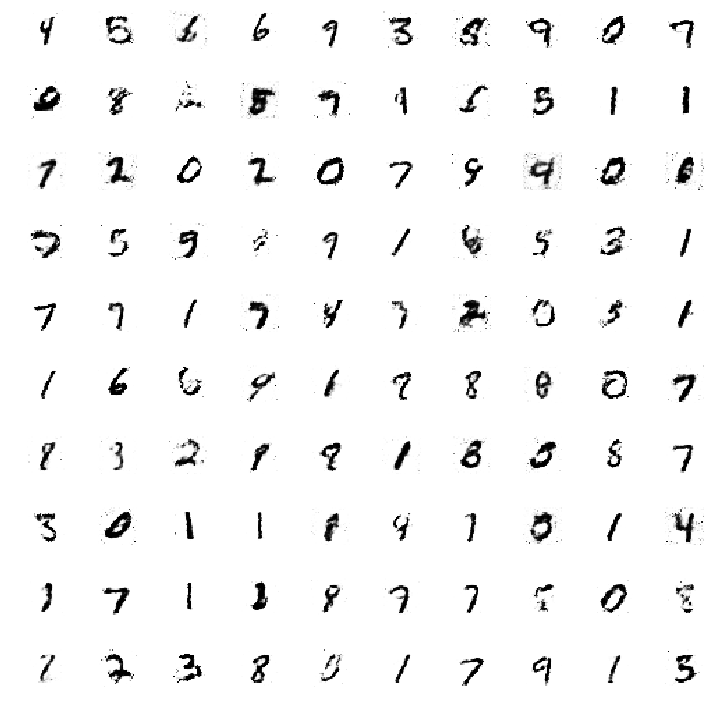

In [ ]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 5 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(400, 128)